In this study, my aim is to utilize the traditional time series model, ARIMA, to forecast the future weekly gross sales for the company. This method diverges from previous steps as it takes into account all customers, including those who haven't registered on the website. Recognizing that non-registered customers also significantly contribute to the company's sales, this inclusive approach is imperative. Due to limitations in tracing original transactions from cancelled ones, the analysis will focus solely on the gross sales.

In [27]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

import warnings

# ignoring warnings
warnings.filterwarnings("ignore")

In [2]:
# Import Whole Dataset
retail = pd.read_excel('../data/Online Retail.xlsx')

In [3]:
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
retail.drop_duplicates(inplace = True)

In [6]:
# Remove all cancelled transaction
retail['InvoiceNo'] = retail['InvoiceNo'].astype('str')

sales = retail[retail['InvoiceNo'].str.contains('C') == False][['Quantity', 'InvoiceDate', 'UnitPrice']]

In [7]:
sales.head()

,Quantity,InvoiceDate,UnitPrice
0,6,2010-12-01 08:26:00,2.55
1,6,2010-12-01 08:26:00,3.39
2,8,2010-12-01 08:26:00,2.75
3,6,2010-12-01 08:26:00,3.39
4,6,2010-12-01 08:26:00,3.39


In [8]:
sales.shape

(527390, 3)

In [9]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 527390 entries, 0 to 541908
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Quantity     527390 non-null  int64         
 1   InvoiceDate  527390 non-null  datetime64[ns]
 2   UnitPrice    527390 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 16.1 MB


In [10]:
# Create columns 'gross_sales' and 'date'
sales['gross_sales'] = sales['Quantity'] * sales['UnitPrice']
sales['date'] = sales['InvoiceDate'].dt.date
sales = sales[['date', 'gross_sales']]

sales.head()

,date,gross_sales
0,2010-12-01,15.30
1,2010-12-01,20.34
2,2010-12-01,22.00
3,2010-12-01,20.34
4,2010-12-01,20.34


In [11]:
# Get daily gross sales
sales_day = sales.groupby('date').agg({'gross_sales': 'sum'}).reset_index()

sales_day

,date,gross_sales
0,2010-12-01,58776.79
1,2010-12-02,47629.42
2,2010-12-03,46898.63
3,2010-12-05,31364.63
4,2010-12-06,54624.15
...,...,...
300,2011-12-05,88620.84
301,2011-12-06,56558.83
302,2011-12-07,75315.55
303,2011-12-08,82371.55


In [12]:
# Convert date to a datetime
sales_day['date'] = pd.to_datetime(sales_day['date'])

sales_day.set_index('date', inplace = True)

sales_day.sort_index(inplace = True)

sales_day.head()

,gross_sales
date,
2010-12-01,58776.79
2010-12-02,47629.42
2010-12-03,46898.63
2010-12-05,31364.63
2010-12-06,54624.15


In [13]:
# Get the weekly gross sales
sales_week = sales_day.resample('W').sum()

sales_week.head()

,gross_sales
date,
2010-12-05,184669.47
2010-12-12,329108.22
2010-12-19,215357.04
2010-12-26,92318.00
2011-01-02,0.00


In [14]:
sales_week.shape

(54, 1)

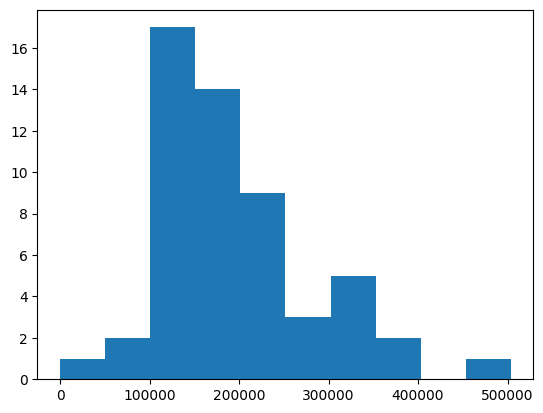

In [15]:
plt.hist(sales_week);

The weekly gross sales is not following normal distribution.

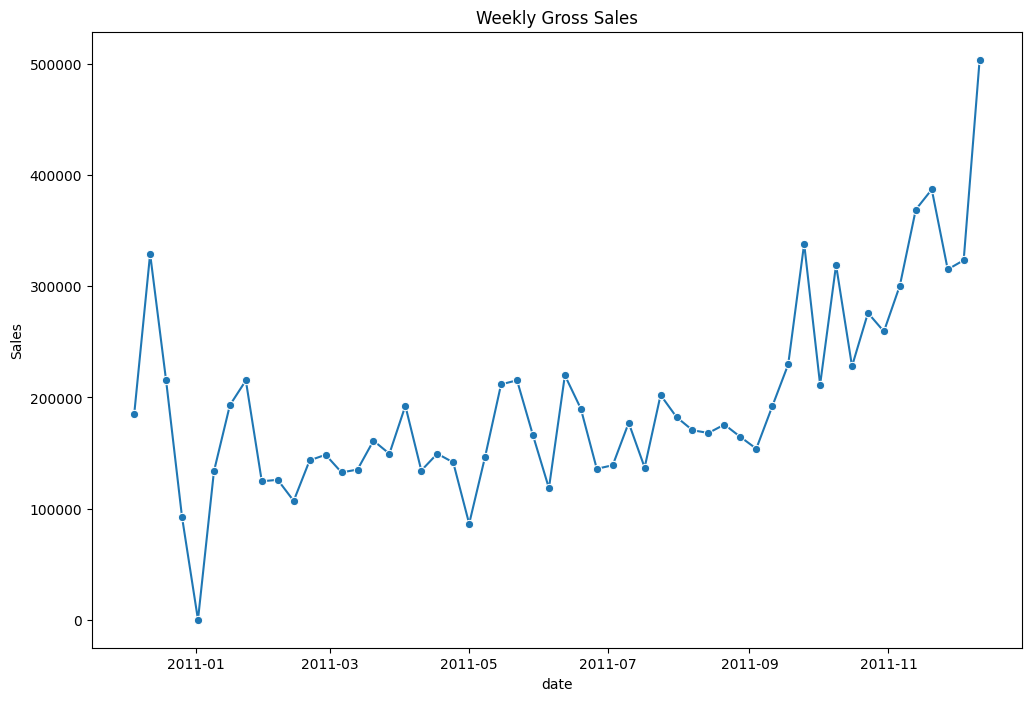

In [16]:
# Create a line chart to visualize how week net sales trends change over time.
plt.figure(figsize = (12, 8))
sns.lineplot(x = sales_week.index, y = 'gross_sales', data = sales_week, marker = 'o')
plt.ylabel('Sales')
plt.title('Weekly Gross Sales');

There is a roughly increased tread. Now we check stationarity using the Augmented Dickey-Fuller Test.

## ARIMA Model

### Stationary: d = 0

In [17]:
adfuller(sales_week['gross_sales'])

(1.2899880841439528,
 0.9965522860101427,
 3,
 50,
 {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616},
 1033.2791008386178)

Given that the p-value of 0.997 exceeds our significance level of 0.01, we do not have sufficient evidence to reject the null hypothesis. As a result, we conclude that the time series data with d = 0 is not stationary.

### Stationary: d = 1

In [18]:
adfuller(sales_week['gross_sales'].diff().dropna())

(-7.900652124689758,
 4.194035914470284e-12,
 2,
 50,
 {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616},
 1010.0346200976013)

The P-value of 0.000 less than the significance level of 0.01. Therefore the time series data with d = 1 is stationary

In [19]:
sales_week['first_diff_sales'] = sales_week['gross_sales'].diff()

sales_week.head()

,gross_sales,first_diff_sales
date,,
2010-12-05,184669.47,NaN
2010-12-12,329108.22,144438.75
2010-12-19,215357.04,-113751.18
2010-12-26,92318.00,-123039.04
2011-01-02,0.00,-92318.00


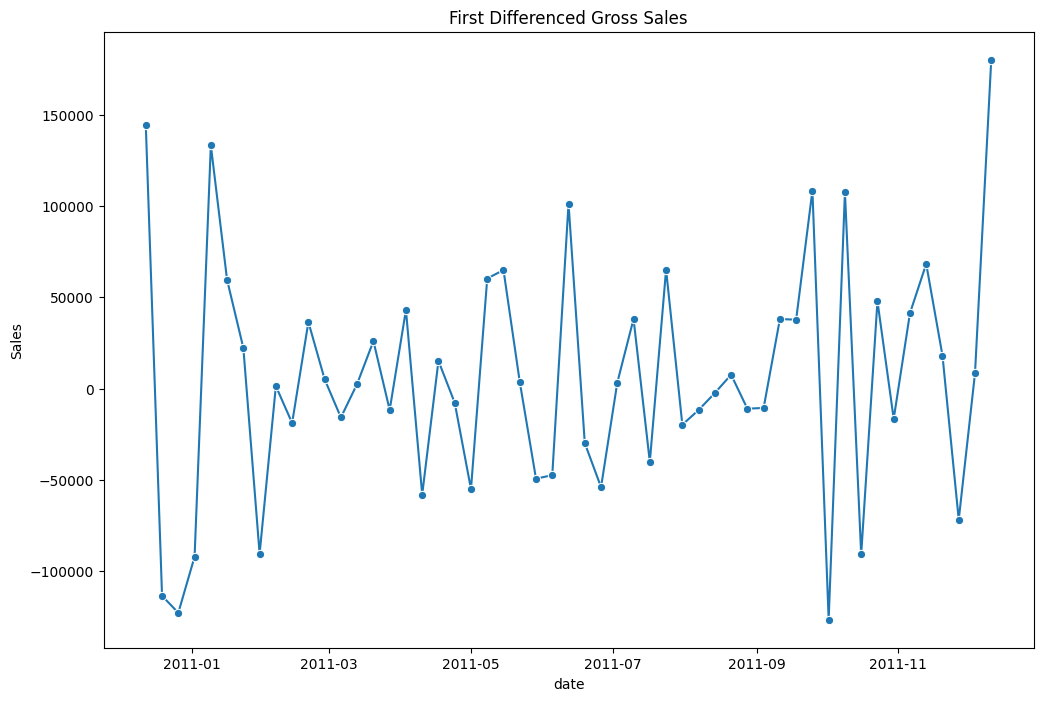

In [20]:
# Examine the net sales, differenced twice
plt.figure(figsize = (12, 8))
sns.lineplot(x = sales_week.index, y = 'first_diff_sales', data = sales_week, marker = 'o')
plt.ylabel('Sales')
plt.title('First Differenced Gross Sales');

In [21]:
# Split train test
y_train, y_test = train_test_split(sales_week['gross_sales'], test_size = 0.1, shuffle = False)

In [22]:
# Find best p and q
best_aic = 999999999
best_p = 0
best_q = 0

for p in range(5):
    for q in range(5):
        try:
            arima = ARIMA(endog=y_train, order = (p, 1, q))
            model = arima.fit()
            
            if model.aic < best_aic:
                best_aic = model.aic
                best_p = p
                best_q = q
        except:
            pass

In [23]:
best_p, best_q

(3, 1)

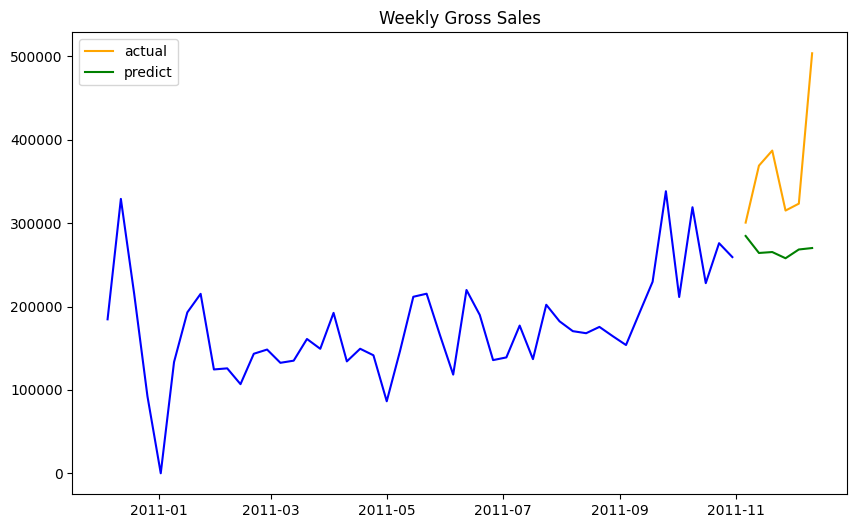

In [30]:
# Initiate best model.
arima = ARIMA(endog = y_train, order = (best_p, 1, best_q))

model = arima.fit()

preds = model.predict(start = y_test.index[0], end = y_test.index[-1])

plt.figure(figsize = (10, 6))

plt.plot(y_train.index, y_train, color = 'blue')
plt.plot(y_test.index, y_test, color = 'orange', label = 'actual')
plt.plot(y_test.index, preds, color = 'green', label = 'predict')

plt.title('Weekly Gross Sales')
plt.legend()
plt.savefig('../graph/arima_predict.png')
plt.show()

In [31]:
mean_squared_error(y_test, preds, squared = False)

120347.91968990439

Given that the root mean square error is 120347, coupled with the graphical representation suggesting poor forecast quality, it's clear that the current model needs refinement. Consequently, it would be prudent to explore the Seasonal ARIMA model as a more appropriate alternative for forecasting.

## Seasonal ARIMA model

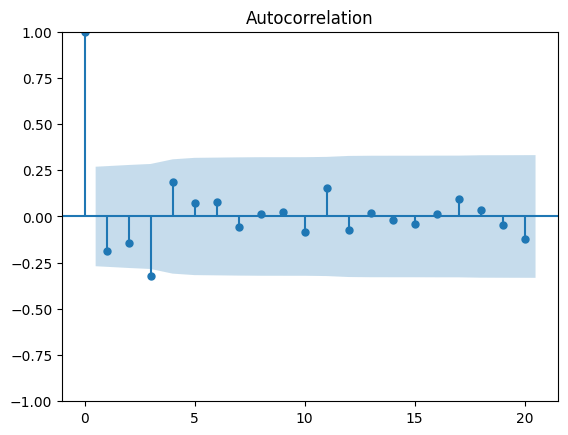

In [32]:
# Check Autocorrelation
plot_acf(sales_week['first_diff_sales'].dropna(), lags = 20);

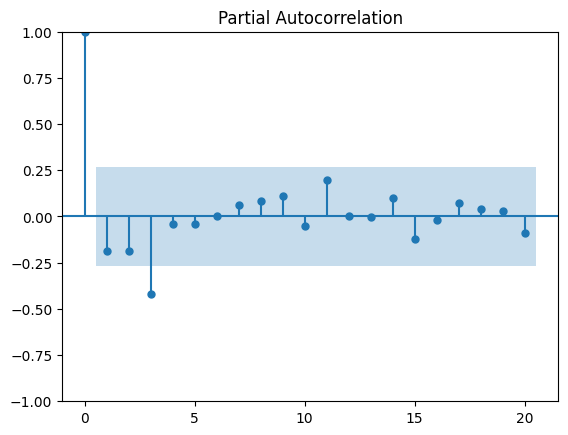

In [33]:
# Check Paritial Autocorrelation
plot_pacf(sales_week['first_diff_sales'].dropna(), lags = 20);

Both graphs indicate that there is seasonality.

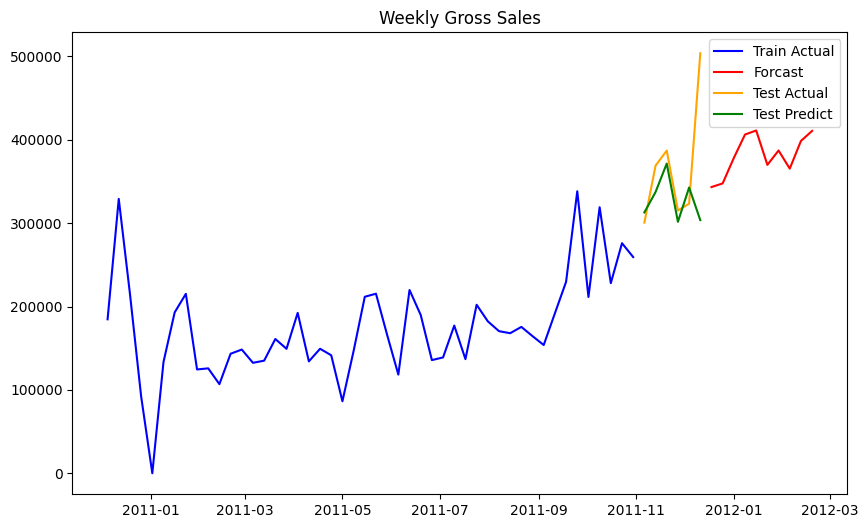

In [35]:
sarima = SARIMAX(endog=y_train, order = (3, 1, 1), seasonal_order=(1, 1, 1, 8))

model = sarima.fit(disp = False)

preds = model.predict(start = y_test.index[0], end = y_test.index[-1])

plt.figure(figsize = (10, 6))

forecast = model.predict(start = y_test.index[-1] + pd.DateOffset(weeks=1), end = y_test.index[-1] + pd.DateOffset(weeks=10))

plt.plot(y_train.index, y_train, color = 'blue', label = 'Train Actual')
plt.plot(forecast.index, forecast, color = 'red', label = 'Forcast')
plt.plot(y_test.index, y_test, color = 'orange', label = 'Test Actual')
plt.plot(y_test.index, preds, color = 'green', label = 'Test Predict')

plt.title('Weekly Gross Sales')
plt.legend()
plt.savefig('../graph/sarima_predict.png')
plt.show()

In [36]:
mean_squared_error(y_test, preds, squared = False)

83676.40951755604

While the model successfully captures the gross sales trends for the initial few weeks, it may not deliver highly accurate predictions over a longer timeframe.